# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction <a name = "introduction"></a>

#### 1.1	Background
Every year pre-med students at colleges and universities in the United States and Canada are researching and applying to medical schools. There is a publication every year by the U.S. News & World Report that ranks the best medical schools and can be used to be more specific regarding medical programs and specialties, and it also includes information such as tuition amounts and enrollment counts. The pre-med students know from their undergraduate careers that it takes a lot of both energy and stress management to be able to succeed as students. For energy, many medical students have learned to use **coffee** and **pizza** to help fuel themselves. In addition to pizza there are plenty of **other types of foods** that different students may enjoy. For stress management, many students will take their coffee or their food outside to a **park** when weather is nice. This project is aimed at identifying which medical schools in the United States and Canada are near a good mix of places to get coffee, pizza places (and other types of restaurants), and parks at which to recreate and enjoy the weather when it is nice.

#### 1.2	Interest
Many pre-med students who are considering many different medical schools would be interested in knowing what sorts of venues are near the medical schools that offer the following:

* Coffee
* Pizza
* Other restaurants
* Parks

## 2. Data <a name = "data"></a>

#### 2.1	Data Sources
For this project, a list of medical schools for the United States and Canada will be needed. The list will need to provide the name and the address of the medical school. The **Association of American Medical Colleges (AAMC)** has the data on a webpage at:
https://members.aamc.org/eweb/DynamicPage.aspx?site=AAMC&webcode=AAMCOrgSearchResult&orgtype=Medical%20School.

The Python library ‘**geocoder**’ with **ArcGIS** will be used to get the latitude and longitude data by using the address data that will be obtained from the AAMC webpage.

The **Foursquare** developers **Places API** will be used to identify venues for coffee, pizza (and other food), and parks that are near the medical schools in the United States and Canada. The Foursquare developers Places API can be found at this webpage: https://foursquare.com/developers/apps.


#### First import the Python libraries required to get the AAMC school data.

In [1]:
# Import the required Python libraries.
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd

#### Get the AAMC member medical school webpage html code.

In [2]:
# Get the AAMC Member Medical School webpage html code.
url = 'https://members.aamc.org/eweb/DynamicPage.aspx?site=AAMC&webcode=AAMCOrgSearchResult&orgtype=Medical%20School'
req = urllib.request.urlopen(url)
article = req.read().decode()

# I could not figure out how to split the AAMC table data on the br tabs so I am replacing them with td tags that I can use to parse through the table data.
article_revised = article.replace('<br>', '</td><td>')

with open('List_of_AAMC_Medical_School_Members', 'w') as fo:
    fo.write(article_revised)

#### Load the webpage, turn it into soup, and extract the tabularized AAMC member medical school data.

In [3]:
## Load webpage, turn into soup, and get the <table>s.
article_revised = open('List_of_AAMC_Medical_School_Members').read()
soup = BeautifulSoup(article_revised, 'html.parser')
tables = soup.find_all('table', class_='bodyTXT')

#Extract data from the AAMC Medical School member tables and load into a Pandas DataFrame.
column_labels = 'Medical_School_Name', 'City_State_Postal_Code', 'Country'
ls = []
for table in tables:
    tds = table.find_all('td')
    if not tds:
        continue
    raw_list = [td.text.strip() for td in tds]
       
    Medical_School_Name, City_State_Postal_Code, Country = None, None, None
    
    Medical_School_Name = raw_list[0]
    try:
        country_index = raw_list.index('UNITED STATES')
    except:
        country_index = raw_list.index('CANADA')
    City_State_Postal_Code = raw_list[country_index - 1]
    Country = raw_list[country_index]    
    data = [Medical_School_Name, City_State_Postal_Code, Country]
    ls.append(data)

df_AAMC_Schools = pd.DataFrame(ls, columns = column_labels)

df_AAMC_Schools    

,Medical_School_Name,City_State_Postal_Code,Country
0,Albany Medical College,"Albany, NY 12208-3412",UNITED STATES
1,Albert Einstein College of Medicine,"Bronx, NY 10461-1900",UNITED STATES
2,Baylor College of Medicine,"Houston, TX 77030-3411",UNITED STATES
3,Boston University School of Medicine,"Boston, MA 02118-2307",UNITED STATES
4,Brody School of Medicine at East Carolina Univ...,"Greenville, NC 27834-4300",UNITED STATES
...,...,...,...
167,Weill Cornell Medicine,"New York, NY 10065-4805",UNITED STATES
168,West Virginia University School of Medicine,"Morgantown, WV 26506-9100",UNITED STATES
169,Western Michigan University Homer Stryker M.D....,"Kalamazoo, MI 49008-1282",UNITED STATES
170,Wright State University Boonshoft School of Me...,"Dayton, OH 45401-0927",UNITED STATES


Excellent, all 172 AAMC member medical schools have been entered into a Pandas DataFrame. Next I will get their coordinates for mapping.

#### Install and import geocoder then use it to get the latitude and longitude coordinates of the AAMC member medical school addresses.

In [4]:
pip install geocoder

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 8.1 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import geocoder

In [6]:
# Define latitude and longitude as lists.
latitude = []
longitude = []

# Loop through the City_State_Postal_Code data in the dataframe and for each location loop until coordinates are obtained.
for City_State_Postal_Code in df_AAMC_Schools['City_State_Postal_Code']:
    g = geocoder.arcgis(City_State_Postal_Code)
    print(City_State_Postal_Code, g.latlng)
    while(g.latlng is None):
        g = geocoder.arcgis(City_State_Postal_Code)
        print(City_State_Postal_Code, g.latlng)
    lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    
df_AAMC_Schools['Latitude'] = latitude
df_AAMC_Schools['Longitude'] = longitude

df_AAMC_Schools

Albany,  NY 12208-3412 [42.65258001752784, -73.77546002798502]
Bronx,  NY 10461-1900 [40.85104998240763, -73.84443001534996]
Houston,  TX 77030-3411 [29.71074000453146, -95.39691999340286]
Boston,  MA 02118-2307 [42.33569001422063, -71.07215996415921]
Greenville,  NC 27834-4300 [35.608359983008526, -77.3986400186078]
Elk Grove,  CA 95757-8145 [38.40504999663915, -121.48047002101339]
Colton,  CA 92324-1603 [34.080040009729586, -117.34486003282706]
Champaign,  IL 61820-6233 [40.108709996616795, -88.22898000861936]
Cleveland,  OH 44106-4915 [41.50589999812931, -81.60905002691273]
Mt Pleasant,  MI 48858-3803 [43.59085000752975, -84.76911000198177]
Boca Raton,  FL 33431-6424 [26.361910014581824, -80.085279960225]
North Chicago,  IL 60064-3037 [42.300060010654875, -87.8610499984869]
New York,  NY 10032-3725 [40.84163999689818, -73.9412900311599]
Camden,  NJ 08103-1211 [39.940389981465586, -75.11936995904864]
Omaha,  NE 68178-0133 [41.26483000873813, -95.94719998349771]
New York,  NY 10031-91

,Medical_School_Name,City_State_Postal_Code,Country,Latitude,Longitude
0,Albany Medical College,"Albany, NY 12208-3412",UNITED STATES,42.65258,-73.77546
1,Albert Einstein College of Medicine,"Bronx, NY 10461-1900",UNITED STATES,40.85105,-73.84443
2,Baylor College of Medicine,"Houston, TX 77030-3411",UNITED STATES,29.71074,-95.39692
3,Boston University School of Medicine,"Boston, MA 02118-2307",UNITED STATES,42.33569,-71.07216
4,Brody School of Medicine at East Carolina Univ...,"Greenville, NC 27834-4300",UNITED STATES,35.60836,-77.39864
...,...,...,...,...,...
167,Weill Cornell Medicine,"New York, NY 10065-4805",UNITED STATES,40.76498,-73.95501
168,West Virginia University School of Medicine,"Morgantown, WV 26506-9100",UNITED STATES,39.64562,-79.95999
169,Western Michigan University Homer Stryker M.D....,"Kalamazoo, MI 49008-1282",UNITED STATES,42.28169,-85.59955
170,Wright State University Boonshoft School of Me...,"Dayton, OH 45401-0927",UNITED STATES,39.75783,-84.17839


#### Install and import Folium then use it to create an overall map of the AAMC member medical schools.

In [7]:
pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.3 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import folium

In [9]:
center_latitude_AAMC = 48
center_longitude_AAMC = -102

map_AAMC = folium.Map(location = [center_latitude_AAMC, center_longitude_AAMC], zoom_start = 3)

for lat, lng, Medical_School_Name, City_State_Postal_Code in zip(df_AAMC_Schools['Latitude'], df_AAMC_Schools['Longitude'], df_AAMC_Schools['Medical_School_Name'], df_AAMC_Schools['City_State_Postal_Code']):
    label = '{}, {}'.format(Medical_School_Name, City_State_Postal_Code)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_AAMC)

map_AAMC

#### Get the selected types of venues near the AAMC member medical schools from Foursquare.
The selected venue categories were obtained from https://developer.foursquare.com/docs/build-with-foursquare/categories/.

In [10]:
# The code was removed by Watson Studio for sharing.

#### Import the required Python libraries for making the URL requests and for defining color coding for later mapping.

In [11]:
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Create the function  that will get the coffee, pizza, other restaurant, and park venues.

In [14]:
def getNearbySelectVenues(names, latitudes, longitudes):
    
    coffee_shop_categoryID = '4bf58dd8d48988d1e0931735'
    pizza_place_categoryID = '4bf58dd8d48988d1ca941735'
    food_categoryID = '4d4b7105d754a06374d81259'
    park_categoryID = '4bf58dd8d48988d163941735'
    food_radius = 500
    park_radius = 200
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL for coffee shops
        coffee_shop_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            food_radius, 
            LIMIT,
            coffee_shop_categoryID)
            
        # make the GET request
        coffee_shop_results = requests.get(coffee_shop_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby coffee shop venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in coffee_shop_results])
                
        # create the API request URL for pizza places
        pizza_place_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            food_radius, 
            LIMIT,
            pizza_place_categoryID)
            
        # make the GET request
        pizza_place_results = requests.get(pizza_place_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby pizza place venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in pizza_place_results])
        
        # create the API request URL for other food venues
        food_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            food_radius, 
            LIMIT,
            food_categoryID)
            
        # make the GET request
        food_results = requests.get(food_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby food venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in food_results])
        

        # create the API request URL for parks
        park_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            park_radius, 
            LIMIT,
            park_categoryID)
            
        # make the GET request
        park_results = requests.get(park_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby park venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in park_results])
        
    nearby_select_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_select_venues.columns = ['Medical_School_Name',
                                    'Medical_School_Latitude',
                                    'Medical_School_Longitude',
                                    'Venue',
                                    'Venue_Latitude',
                                    'Venue_Longitude',
                                    'Venue_Category']
        
    return(nearby_select_venues)

I had to experiment with setting the radius to different values to work around variable Foursquare API call results that often created errors and resulted in no data being pulled. Unfortunately, I had to set the radius to only 500 meters for the food venues and 200 meters for the park venues. I would have preferred to have been able to do a radius of at least 800 meters for all venues which would be about a 0.5 mile radius.

#### Use the previously defined function to get the selected venues that are near the AAMC member medical schools.

In [17]:
df_AAMC_school_select_venues = getNearbySelectVenues(names = df_AAMC_Schools['Medical_School_Name'],
                                                     latitudes = df_AAMC_Schools['Latitude'],
                                                     longitudes = df_AAMC_Schools['Longitude']
                                                    )

Albany Medical College
Albert Einstein College of Medicine
Baylor College of Medicine
Boston University School of Medicine
Brody School of Medicine at East Carolina University
California Northstate University College of Medicine
California University of Science and Medicine-School of Medicine
Carle Illinois College of Medicine
Case Western Reserve University School of Medicine
Central Michigan University College of Medicine
Charles E. Schmidt College of Medicine at Florida Atlantic University
Chicago Medical School at Rosalind Franklin University of Medicine & Science
Columbia University Vagelos College of Physicians and Surgeons
Cooper Medical School of Rowan University
Creighton University School of Medicine
CUNY School of Medicine
Dalhousie University Faculty of Medicine
Donald and Barbara Zucker School of Medicine at Hofstra/Northwell
Drexel University College of Medicine
Duke University School of Medicine
East Tennessee State University James H. Quillen College of Medicine
Eastern

## 3. Methodology <a name = "methodology"></a>

In this project I will use **Pandas DataFrames** to show the top 25 AAMC member medical schools with the most coffee shops, pizza places, and parks nearby. I will also use **Folium maps** to show all the AAMC member medical schools with color coding that indicates which ones have more or less coffee shops, pizza places, and parks nearby. For the other restaurants I will use **k-means clustering** to group the AAMC member medical schools together by what they have in common, and I will use the **elbow method** using distortion and inertia to identify the best value for k. I will display the clusters as Pandas DataFrames and simply look at them to describe the clusters.

## 4. Analysis <a name = "analysis"></a>

#### Do some initial exploratory analysis to see how well the data gathering did.

In [18]:
df_AAMC_school_select_venues

,Medical_School_Name,Medical_School_Latitude,Medical_School_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Albany Medical College,42.65258,-73.77546,Starbucks,42.652294,-73.776190,Coffee Shop
1,Albany Medical College,42.65258,-73.77546,Choices Cafe at Albany Medical Center,42.653701,-73.775963,Café
2,Albany Medical College,42.65258,-73.77546,Tim Hortons,42.650411,-73.779171,Coffee Shop
3,Albany Medical College,42.65258,-73.77546,Choices Cafe at Albany Medical Center,42.653701,-73.775963,Café
4,Albany Medical College,42.65258,-73.77546,Stewart's Shops,42.654289,-73.772742,Convenience Store
...,...,...,...,...,...,...,...
4294,Yale School of Medicine,41.30300,-72.93400,Yale New Haven Hospital Cafeteria,41.304803,-72.935407,Cafeteria
4295,Yale School of Medicine,41.30300,-72.93400,Park Street Cafe,41.304785,-72.936091,Café
4296,Yale School of Medicine,41.30300,-72.93400,Imperial Wok,41.304817,-72.937410,Restaurant
4297,Yale School of Medicine,41.30300,-72.93400,Gennaro's Apizza Cafe,41.304817,-72.937410,Pizza Place


It looks like I got some duplicate food venues which is not a surprise. I'll remove duplicate rows now.

In [78]:
df_AAMC_school_select_venues.drop_duplicates(inplace = True)
df_AAMC_school_select_venues

,Medical_School_Name,Medical_School_Latitude,Medical_School_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Albany Medical College,42.65258,-73.77546,Starbucks,42.652294,-73.776190,Coffee Shop
1,Albany Medical College,42.65258,-73.77546,Choices Cafe at Albany Medical Center,42.653701,-73.775963,Café
2,Albany Medical College,42.65258,-73.77546,Tim Hortons,42.650411,-73.779171,Coffee Shop
4,Albany Medical College,42.65258,-73.77546,Stewart's Shops,42.654289,-73.772742,Convenience Store
5,Albany Medical College,42.65258,-73.77546,I Love NY Pizza,42.654055,-73.772886,Pizza Place
...,...,...,...,...,...,...,...
4289,Yale School of Medicine,41.30300,-72.93400,SUBWAY,41.304999,-72.934257,Sandwich Place
4292,Yale School of Medicine,41.30300,-72.93400,Liu's Lunch,41.303683,-72.934634,Food Truck
4294,Yale School of Medicine,41.30300,-72.93400,Yale New Haven Hospital Cafeteria,41.304803,-72.935407,Cafeteria
4296,Yale School of Medicine,41.30300,-72.93400,Imperial Wok,41.304817,-72.937410,Restaurant


In [79]:
df_AAMC_school_select_venues.groupby('Medical_School_Name').count()

,Medical_School_Latitude,Medical_School_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Medical_School_Name,,,,,,
Albany Medical College,16,16,16,16,16,16
Albert Einstein College of Medicine,21,21,21,21,21,21
Baylor College of Medicine,35,35,35,35,35,35
Boston University School of Medicine,41,41,41,41,41,41
Brody School of Medicine at East Carolina University,15,15,15,15,15,15
...,...,...,...,...,...,...
Wayne State University School of Medicine,20,20,20,20,20,20
Weill Cornell Medicine,66,66,66,66,66,66
West Virginia University School of Medicine,7,7,7,7,7,7


How many unique categories are there?

In [80]:
print('There are {} unique categories.'.format(len(df_AAMC_school_select_venues.Venue_Category.unique())))

There are 132 unique categories.


#### Identify venues categorized as coffee shops and cafes. Rank the AAMC member medical schools from most to least coffee shop and cafe venues.

In [81]:
df_AAMC_school_coffee_shops = df_AAMC_school_select_venues[(df_AAMC_school_select_venues.Venue_Category == 'Coffee Shop') | (df_AAMC_school_select_venues.Venue_Category == 'Café')]

df_AAMC_school_coffee_shops_grouped = df_AAMC_school_coffee_shops.groupby('Medical_School_Name').count()

df_AAMC_school_coffee_shops_grouped.rename(columns = {'Medical_School_Latitude': 'Coffee_Shop_Count'}, inplace = True)

df_AAMC_school_coffee_shops_grouped.drop(['Medical_School_Longitude', 'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category'], axis = 1, inplace = True)

df_AAMC_school_coffee_shops_grouped['Coffee_Shop_Count_Scaled'] = df_AAMC_school_coffee_shops_grouped['Coffee_Shop_Count'] / df_AAMC_school_coffee_shops_grouped['Coffee_Shop_Count'].max()

df_AAMC_school_coffee_shops_grouped.sort_values(by = ['Coffee_Shop_Count'], ascending = False, inplace = True)

df_AAMC_school_coffee_shops_grouped.head(25)

,Coffee_Shop_Count,Coffee_Shop_Count_Scaled
Medical_School_Name,,
University of Washington School of Medicine,23,1.000000
Sidney Kimmel Medical College at Thomas Jefferson University,22,0.956522
Tufts University School of Medicine,22,0.956522
"University of California, Los Angeles David Geffen School of Medicine",22,0.956522
Northwestern University The Feinberg School of Medicine,21,0.913043
Harvard Medical School,21,0.913043
University of British Columbia Faculty of Medicine,19,0.826087
Weill Cornell Medicine,18,0.782609
Washington State University Elson S. Floyd College of Medicine,18,0.782609


#### Create a dataframe for mapping the AAMC member medical schools based on their coffee shop and cafe rank.

In [82]:
df_AAMC_school_coffee_shops_for_map = df_AAMC_Schools.join(df_AAMC_school_coffee_shops_grouped,on = 'Medical_School_Name')

df_AAMC_school_coffee_shops_for_map['Coffee_Shop_Count'].fillna(value = 0, inplace = True)

df_AAMC_school_coffee_shops_for_map['Coffee_Shop_Count_Scaled'].fillna(value = 0, inplace = True)

df_AAMC_school_coffee_shops_for_map

,Medical_School_Name,City_State_Postal_Code,Country,Latitude,Longitude,Coffee_Shop_Count,Coffee_Shop_Count_Scaled
0,Albany Medical College,"Albany, NY 12208-3412",UNITED STATES,42.65258,-73.77546,3.0,0.130435
1,Albert Einstein College of Medicine,"Bronx, NY 10461-1900",UNITED STATES,40.85105,-73.84443,3.0,0.130435
2,Baylor College of Medicine,"Houston, TX 77030-3411",UNITED STATES,29.71074,-95.39692,13.0,0.565217
3,Boston University School of Medicine,"Boston, MA 02118-2307",UNITED STATES,42.33569,-71.07216,5.0,0.217391
4,Brody School of Medicine at East Carolina Univ...,"Greenville, NC 27834-4300",UNITED STATES,35.60836,-77.39864,1.0,0.043478
...,...,...,...,...,...,...,...
167,Weill Cornell Medicine,"New York, NY 10065-4805",UNITED STATES,40.76498,-73.95501,18.0,0.782609
168,West Virginia University School of Medicine,"Morgantown, WV 26506-9100",UNITED STATES,39.64562,-79.95999,1.0,0.043478
169,Western Michigan University Homer Stryker M.D....,"Kalamazoo, MI 49008-1282",UNITED STATES,42.28169,-85.59955,0.0,0.000000
170,Wright State University Boonshoft School of Me...,"Dayton, OH 45401-0927",UNITED STATES,39.75783,-84.17839,6.0,0.260870


#### Map the AAMC member medical schools using a darker brown shading for locations with more coffee shop and cafe venues nearby.

In [83]:
center_latitude_AAMC = 48
center_longitude_AAMC = -102

map_AAMC_coffee_shops = folium.Map(location = [center_latitude_AAMC, center_longitude_AAMC], zoom_start = 3)

for lat, lng, Medical_School_Name, City_State_Postal_Code, Coffee_Shop_Count, Coffee_Shop_Count_Scaled in zip(df_AAMC_school_coffee_shops_for_map['Latitude'], df_AAMC_school_coffee_shops_for_map['Longitude'], df_AAMC_school_coffee_shops_for_map['Medical_School_Name'], df_AAMC_school_coffee_shops_for_map['City_State_Postal_Code'], df_AAMC_school_coffee_shops_for_map['Coffee_Shop_Count'], df_AAMC_school_coffee_shops_for_map['Coffee_Shop_Count_Scaled']):
    label = '{}, {}, {} coffee shops'.format(Medical_School_Name, City_State_Postal_Code, int(Coffee_Shop_Count))
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'brown',
        fill = True,
        fill_color = '#6F4E37',
        fill_opacity = Coffee_Shop_Count_Scaled,
        parse_html = False).add_to(map_AAMC_coffee_shops)

map_AAMC_coffee_shops

#### Identify venues categorized as pizza places. Rank the AAMC member medical schools from most to least pizza places.

In [84]:
df_AAMC_school_pizza_places = df_AAMC_school_select_venues[(df_AAMC_school_select_venues.Venue_Category == 'Pizza Place')]

df_AAMC_school_pizza_places_grouped = df_AAMC_school_pizza_places.groupby('Medical_School_Name').count()

df_AAMC_school_pizza_places_grouped.rename(columns = {'Medical_School_Latitude': 'Pizza_Place_Count'}, inplace = True)

df_AAMC_school_pizza_places_grouped.drop(['Medical_School_Longitude', 'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category'], axis = 1, inplace = True)

df_AAMC_school_pizza_places_grouped['Pizza_Place_Count_Scaled'] = df_AAMC_school_pizza_places_grouped['Pizza_Place_Count'] / df_AAMC_school_pizza_places_grouped['Pizza_Place_Count'].max()

df_AAMC_school_pizza_places_grouped.sort_values(by = ['Pizza_Place_Count'], ascending = False, inplace = True)

df_AAMC_school_pizza_places_grouped.head(25)

,Pizza_Place_Count,Pizza_Place_Count_Scaled
Medical_School_Name,,
New York University Grossman School of Medicine,21,1.000000
Sidney Kimmel Medical College at Thomas Jefferson University,18,0.857143
Weill Cornell Medicine,12,0.571429
Columbia University Vagelos College of Physicians and Surgeons,11,0.523810
CUNY School of Medicine,10,0.476190
"University of California, Los Angeles David Geffen School of Medicine",9,0.428571
Icahn School of Medicine at Mount Sinai,8,0.380952
Howard University College of Medicine,7,0.333333
State University of New York Upstate Medical University,7,0.333333


#### Create a dataframe for mapping the AAMC member medical schools based on their pizza place rank.

In [85]:
df_AAMC_school_pizza_places_for_map = df_AAMC_Schools.join(df_AAMC_school_pizza_places_grouped,on = 'Medical_School_Name')

df_AAMC_school_pizza_places_for_map['Pizza_Place_Count'].fillna(value = 0, inplace = True)

df_AAMC_school_pizza_places_for_map['Pizza_Place_Count_Scaled'].fillna(value = 0, inplace = True)

df_AAMC_school_pizza_places_for_map

,Medical_School_Name,City_State_Postal_Code,Country,Latitude,Longitude,Pizza_Place_Count,Pizza_Place_Count_Scaled
0,Albany Medical College,"Albany, NY 12208-3412",UNITED STATES,42.65258,-73.77546,3.0,0.142857
1,Albert Einstein College of Medicine,"Bronx, NY 10461-1900",UNITED STATES,40.85105,-73.84443,2.0,0.095238
2,Baylor College of Medicine,"Houston, TX 77030-3411",UNITED STATES,29.71074,-95.39692,1.0,0.047619
3,Boston University School of Medicine,"Boston, MA 02118-2307",UNITED STATES,42.33569,-71.07216,3.0,0.142857
4,Brody School of Medicine at East Carolina Univ...,"Greenville, NC 27834-4300",UNITED STATES,35.60836,-77.39864,0.0,0.000000
...,...,...,...,...,...,...,...
167,Weill Cornell Medicine,"New York, NY 10065-4805",UNITED STATES,40.76498,-73.95501,12.0,0.571429
168,West Virginia University School of Medicine,"Morgantown, WV 26506-9100",UNITED STATES,39.64562,-79.95999,0.0,0.000000
169,Western Michigan University Homer Stryker M.D....,"Kalamazoo, MI 49008-1282",UNITED STATES,42.28169,-85.59955,0.0,0.000000
170,Wright State University Boonshoft School of Me...,"Dayton, OH 45401-0927",UNITED STATES,39.75783,-84.17839,1.0,0.047619


#### Map the AAMC member medical schools using a darker red shading for locations with more pizza place venues nearby.

In [86]:
center_latitude_AAMC = 48
center_longitude_AAMC = -102

map_AAMC_pizza_places = folium.Map(location = [center_latitude_AAMC, center_longitude_AAMC], zoom_start = 3)

for lat, lng, Medical_School_Name, City_State_Postal_Code, Pizza_Place_Count, Pizza_Place_Count_Scaled in zip(df_AAMC_school_pizza_places_for_map['Latitude'], df_AAMC_school_pizza_places_for_map['Longitude'], df_AAMC_school_pizza_places_for_map['Medical_School_Name'], df_AAMC_school_pizza_places_for_map['City_State_Postal_Code'], df_AAMC_school_pizza_places_for_map['Pizza_Place_Count'], df_AAMC_school_pizza_places_for_map['Pizza_Place_Count_Scaled']):
    label = '{}, {}, {} pizza places'.format(Medical_School_Name, City_State_Postal_Code, int(Pizza_Place_Count))
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#FF6347',
        fill_opacity = Pizza_Place_Count_Scaled,
        parse_html = False).add_to(map_AAMC_pizza_places)

map_AAMC_pizza_places

#### Identify venues categorized as parks. Rank the AAMC member medical schools from most to least parks.

In [87]:
df_AAMC_school_parks = df_AAMC_school_select_venues[(df_AAMC_school_select_venues.Venue_Category == 'Park')]

df_AAMC_school_parks_grouped = df_AAMC_school_parks.groupby('Medical_School_Name').count()

df_AAMC_school_parks_grouped.rename(columns = {'Medical_School_Latitude': 'Park_Count'}, inplace = True)

df_AAMC_school_parks_grouped.drop(['Medical_School_Longitude', 'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category'], axis = 1, inplace = True)

df_AAMC_school_parks_grouped['Park_Count_Scaled'] = df_AAMC_school_parks_grouped['Park_Count'] / df_AAMC_school_parks_grouped['Park_Count'].max()

df_AAMC_school_parks_grouped.sort_values(by = ['Park_Count'], ascending = False, inplace = True)

df_AAMC_school_parks_grouped.head(25)

,Park_Count,Park_Count_Scaled
Medical_School_Name,,
Columbia University Vagelos College of Physicians and Surgeons,4,1.00
George Washington University School of Medicine and Health Sciences,2,0.50
Northwestern University The Feinberg School of Medicine,2,0.50
Ohio State University College of Medicine,2,0.50
State University of New York Downstate Medical Center College of Medicine,2,0.50
Tufts University School of Medicine,2,0.50
CUNY School of Medicine,1,0.25
"University of Hawaii, John A. Burns School of Medicine",1,0.25
Wake Forest School of Medicine of Wake Forest Baptist Medical Center,1,0.25


#### Create a dataframe for mapping the AAMC member medical schools based on their park rank.

In [88]:
df_AAMC_school_parks_for_map = df_AAMC_Schools.join(df_AAMC_school_parks_grouped,on = 'Medical_School_Name')

df_AAMC_school_parks_for_map['Park_Count'].fillna(value = 0, inplace = True)

df_AAMC_school_parks_for_map['Park_Count_Scaled'].fillna(value = 0, inplace = True)

df_AAMC_school_parks_for_map

,Medical_School_Name,City_State_Postal_Code,Country,Latitude,Longitude,Park_Count,Park_Count_Scaled
0,Albany Medical College,"Albany, NY 12208-3412",UNITED STATES,42.65258,-73.77546,0.0,0.0
1,Albert Einstein College of Medicine,"Bronx, NY 10461-1900",UNITED STATES,40.85105,-73.84443,0.0,0.0
2,Baylor College of Medicine,"Houston, TX 77030-3411",UNITED STATES,29.71074,-95.39692,0.0,0.0
3,Boston University School of Medicine,"Boston, MA 02118-2307",UNITED STATES,42.33569,-71.07216,0.0,0.0
4,Brody School of Medicine at East Carolina Univ...,"Greenville, NC 27834-4300",UNITED STATES,35.60836,-77.39864,0.0,0.0
...,...,...,...,...,...,...,...
167,Weill Cornell Medicine,"New York, NY 10065-4805",UNITED STATES,40.76498,-73.95501,0.0,0.0
168,West Virginia University School of Medicine,"Morgantown, WV 26506-9100",UNITED STATES,39.64562,-79.95999,0.0,0.0
169,Western Michigan University Homer Stryker M.D....,"Kalamazoo, MI 49008-1282",UNITED STATES,42.28169,-85.59955,0.0,0.0
170,Wright State University Boonshoft School of Me...,"Dayton, OH 45401-0927",UNITED STATES,39.75783,-84.17839,0.0,0.0


#### Map the AAMC member medical schools using a darker green shading for locations with more park venues nearby.

In [89]:
center_latitude_AAMC = 48
center_longitude_AAMC = -102

map_AAMC_parks = folium.Map(location = [center_latitude_AAMC, center_longitude_AAMC], zoom_start = 3)

for lat, lng, Medical_School_Name, City_State_Postal_Code, Park_Count, Park_Count_Scaled in zip(df_AAMC_school_parks_for_map['Latitude'], df_AAMC_school_parks_for_map['Longitude'], df_AAMC_school_parks_for_map['Medical_School_Name'], df_AAMC_school_parks_for_map['City_State_Postal_Code'], df_AAMC_school_parks_for_map['Park_Count'], df_AAMC_school_parks_for_map['Park_Count_Scaled']):
    label = '{}, {}, {} parks'.format(Medical_School_Name, City_State_Postal_Code, int(Park_Count))
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#0B6623',
        fill_opacity = Park_Count_Scaled,
        parse_html = False).add_to(map_AAMC_parks)

map_AAMC_parks

#### Identify all other types of venues besides coffee shops, cafes, pizza places, and parks.

In [90]:
df_AAMC_School_other_venues = df_AAMC_school_select_venues[~df_AAMC_school_select_venues['Venue_Category'].isin(['Coffee Shop', 'Café', 'Pizza Place', 'Park'])]

#### Use one hot encoding to translate the categorical data to numbers that we can use in calculations.

In [91]:
# one hot encoding
df_AAMC_School_other_venues_onehot = pd.get_dummies(df_AAMC_School_other_venues[['Venue_Category']], prefix = "", prefix_sep = "")

# add Medical School Name column back to dataframe
df_AAMC_School_other_venues_onehot['Medical_School_Name'] = df_AAMC_School_other_venues['Medical_School_Name']

# move Medical School Name column to the first column
fixed_columns = [df_AAMC_School_other_venues_onehot.columns[-1]] + list(df_AAMC_School_other_venues_onehot.columns[:-1])
df_AAMC_School_other_venues_onehot = df_AAMC_School_other_venues_onehot[fixed_columns]

df_AAMC_School_other_venues_onehot.head()

,Medical_School_Name,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Winery,Wings Joint
4,Albany Medical College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Albany Medical College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Albany Medical College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Albany Medical College,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11,Albany Medical College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Examine DataFrame size.

In [92]:
df_AAMC_School_other_venues_onehot.shape

(2407, 129)

#### Group rows by AAMC memeber medical school and by taking the mean of the frequency of occurrence of each category.

In [93]:
df_AAMC_School_other_venues_grouped = df_AAMC_School_other_venues_onehot.groupby('Medical_School_Name').mean().reset_index()
df_AAMC_School_other_venues_grouped

,Medical_School_Name,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Winery,Wings Joint
0,Albany Medical College,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,Albert Einstein College of Medicine,0.000000,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,Baylor College of Medicine,0.000000,0.000000,0.238095,0.000000,0.000000,0.0,0.095238,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Boston University School of Medicine,0.000000,0.030303,0.030303,0.030303,0.090909,0.0,0.000000,0.000000,0.030303,...,0.000000,0.0,0.030303,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Brody School of Medicine at East Carolina Univ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Wayne State University School of Medicine,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.083333,0.0,0.000000,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000
163,Weill Cornell Medicine,0.027778,0.000000,0.027778,0.000000,0.000000,0.0,0.000000,0.055556,0.027778,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.027778,0.0,0.0,0.000000
164,West Virginia University School of Medicine,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,...,0.166667,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667
165,Wright State University Boonshoft School of Me...,0.000000,0.000000,0.222222,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


#### Now get this information into a Pandas DataFrame.
First, write a function to sort the venues in descending order.

In [94]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Oh, and I need to import numbpy; better do that now.

In [95]:
import numpy as np

Now create a new DataFrame for the top ten other restaurant venues for each AAMC member medical school.

In [96]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Medical_School_Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))
        
# create a new dataframe
AAMC_schools_venues_sorted = pd.DataFrame(columns = columns)
AAMC_schools_venues_sorted['Medical_School_Name'] = df_AAMC_School_other_venues_grouped['Medical_School_Name']

for ind in np.arange(df_AAMC_School_other_venues_grouped.shape[0]):
    AAMC_schools_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_AAMC_School_other_venues_grouped.iloc[ind, :], num_top_venues)
    
AAMC_schools_venues_sorted.head()

,Medical_School_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Medical College,Bar,Sushi Restaurant,Food,Convenience Store,Donut Shop,Chinese Restaurant,Mexican Restaurant,Bakery,Sandwich Place,Italian Restaurant
1,Albert Einstein College of Medicine,Deli / Bodega,Food Truck,Food Court,Food,Sandwich Place,Sushi Restaurant,Donut Shop,Bus Line,Buffet,American Restaurant
2,Baylor College of Medicine,American Restaurant,Salad Place,Breakfast Spot,Restaurant,Burger Joint,BBQ Joint,Mexican Restaurant,Sandwich Place,Food,Food Court
3,Boston University School of Medicine,Asian Restaurant,Donut Shop,Sandwich Place,Diner,Deli / Bodega,Breakfast Spot,Tapas Restaurant,Food Truck,Mediterranean Restaurant,Sushi Restaurant
4,Brody School of Medicine at East Carolina Univ...,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Chinese Restaurant,Seafood Restaurant,Breakfast Spot,Wings Joint,Event Space,Ethiopian Restaurant,Empanada Restaurant


#### Cluster the AAMC member medical schools.
First import k-means and determined the best value for k using the elbow method (distortion and inertia).

In [97]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [98]:
df_AAMC_School_other_venues_grouped_clustering = df_AAMC_School_other_venues_grouped.drop('Medical_School_Name', 1)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
k_range = range(1,21)

for k in k_range:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters = k).fit(df_AAMC_School_other_venues_grouped_clustering)
    kmeanModel.fit(df_AAMC_School_other_venues_grouped_clustering)
    
    distortions.append(sum(np.min(cdist(df_AAMC_School_other_venues_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis = 1)) / df_AAMC_School_other_venues_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = sum(np.min(cdist(df_AAMC_School_other_venues_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis =1)) / df_AAMC_School_other_venues_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [99]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.39751859354261065
2 : 0.38074401732866725
3 : 0.3700055564416048
4 : 0.3584581162552389
5 : 0.34859224881763023
6 : 0.34364024138709076
7 : 0.33486753771431677
8 : 0.3267092389817387
9 : 0.3237361423051477
10 : 0.31592421976274027
11 : 0.31275337773807554
12 : 0.30809770970760086
13 : 0.3006882408177975
14 : 0.2961417373401724
15 : 0.29580552213686556
16 : 0.29293627260165045
17 : 0.2850716728560028
18 : 0.2834706847223656
19 : 0.28093970490311987
20 : 0.2757808198611635


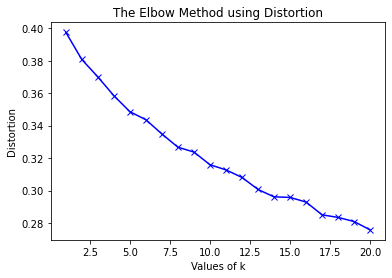

In [100]:
plt.plot(k_range, distortions, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [101]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 32.32393753385572
2 : 29.525789221807663
3 : 27.699971536190954
4 : 26.07861631150947
5 : 24.483904934293626
6 : 23.476239440438196
7 : 21.957455512199502
8 : 21.039522009381074
9 : 20.290194978433618
10 : 19.718333964668602
11 : 19.07724955771873
12 : 18.54464059129258
13 : 17.461800872286716
14 : 16.69372111614781
15 : 16.768795974342623
16 : 16.29355314068409
17 : 15.680239820058178
18 : 15.61708879264556
19 : 15.228905407732496
20 : 14.571665595871567


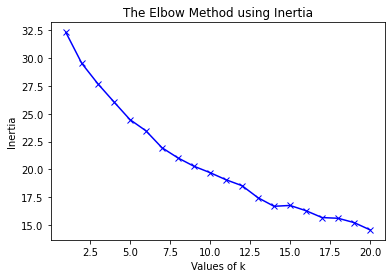

In [102]:
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

There is not a strong elbow in either the distortion or the inertia, but the values seem to level off after 14 so I am uisng 14 for the value for k.

In [103]:
# set number of clusters
kclusters = 14

df_AAMC_School_other_venues_grouped_clustering = df_AAMC_School_other_venues_grouped.drop('Medical_School_Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(df_AAMC_School_other_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 8,  8,  3,  8, 10,  8,  8,  8,  8, 10], dtype=int32)

Add the cluster labels and top ten venues to the original AAMC member medical school DataFrame.

In [104]:
# add clustering lables
AAMC_schools_venues_sorted.insert(0, 'Cluster labels', kmeans.labels_)

In [105]:
df_AAMC_schools_venues_merged = df_AAMC_Schools

df_AAMC_schools_venues_merged = df_AAMC_schools_venues_merged.join(AAMC_schools_venues_sorted.set_index('Medical_School_Name'), on = 'Medical_School_Name', how = 'right')

df_AAMC_schools_venues_merged.head()

,Medical_School_Name,City_State_Postal_Code,Country,Latitude,Longitude,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Medical College,"Albany, NY 12208-3412",UNITED STATES,42.65258,-73.77546,8,Bar,Sushi Restaurant,Food,Convenience Store,Donut Shop,Chinese Restaurant,Mexican Restaurant,Bakery,Sandwich Place,Italian Restaurant
1,Albert Einstein College of Medicine,"Bronx, NY 10461-1900",UNITED STATES,40.85105,-73.84443,8,Deli / Bodega,Food Truck,Food Court,Food,Sandwich Place,Sushi Restaurant,Donut Shop,Bus Line,Buffet,American Restaurant
2,Baylor College of Medicine,"Houston, TX 77030-3411",UNITED STATES,29.71074,-95.39692,3,American Restaurant,Salad Place,Breakfast Spot,Restaurant,Burger Joint,BBQ Joint,Mexican Restaurant,Sandwich Place,Food,Food Court
3,Boston University School of Medicine,"Boston, MA 02118-2307",UNITED STATES,42.33569,-71.07216,8,Asian Restaurant,Donut Shop,Sandwich Place,Diner,Deli / Bodega,Breakfast Spot,Tapas Restaurant,Food Truck,Mediterranean Restaurant,Sushi Restaurant
4,Brody School of Medicine at East Carolina Univ...,"Greenville, NC 27834-4300",UNITED STATES,35.60836,-77.39864,10,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Chinese Restaurant,Seafood Restaurant,Breakfast Spot,Wings Joint,Event Space,Ethiopian Restaurant,Empanada Restaurant


#### Create a map of the AAMC member medical schools with color coding for the different clusters.

In [106]:
# create map
map_clusters = folium.Map(location = [center_latitude_AAMC, center_longitude_AAMC], zoom_start = 3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_AAMC_schools_venues_merged['Latitude'], df_AAMC_schools_venues_merged['Longitude'], df_AAMC_schools_venues_merged['Medical_School_Name'], df_AAMC_schools_venues_merged['Cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
    
map_clusters

That looks like someone put jelly beans all over a map of the United States and Canada. Happy Easter to those who celebrate it!

#### Look at and describe the 14 individual clusters.

#### Cluster 1: Lots of AAMC member medical schools with food trucks, deli/bodegas, and bakeries

In [107]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 0, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Drexel University College of Medicine,0,Bakery,Diner,Residential Building (Apartment / Condo),Food Truck,Snack Place,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Fast Food Restaurant
35,Indiana University School of Medicine,0,Food Truck,Mexican Restaurant,Sandwich Place,Burger Joint,Restaurant,Breakfast Spot,Chinese Restaurant,Fast Food Restaurant,American Restaurant,Diner
39,Keck School of Medicine of the University of S...,0,Restaurant,Mexican Restaurant,Food Truck,Sandwich Place,Chinese Restaurant,Cafeteria,Fried Chicken Joint,Thai Restaurant,Taco Place,Mediterranean Restaurant
40,Lewis Katz School of Medicine at Temple Univer...,0,Breakfast Spot,Food Truck,Chinese Restaurant,Food Court,Sandwich Place,Salad Place,Restaurant,Cafeteria,Caribbean Restaurant,Food
41,Loma Linda University School of Medicine,0,Vegetarian / Vegan Restaurant,Cafeteria,Restaurant,Mexican Restaurant,Wings Joint,Dumpling Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Donut Shop
42,Louisiana State University School of Medicine ...,0,Food Truck,Vietnamese Restaurant,Sandwich Place,Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Wings Joint,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant
45,Marshall University Joan C. Edwards School of ...,0,Burger Joint,Comfort Food Restaurant,Mexican Restaurant,Fast Food Restaurant,Field,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop
46,"Max Rady College of Medicine, Rady Faculty of ...",0,Hot Dog Joint,Vietnamese Restaurant,Restaurant,Taco Place,Fast Food Restaurant,Dumpling Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant
52,Medical College of Wisconsin,0,Deli / Bodega,Cafeteria,Fast Food Restaurant,Steakhouse,Food Court,Food Truck,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant
58,Morehouse School of Medicine,0,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Food Truck,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Wings Joint,Field


#### Cluster 2: Lots of AAMC member medical schools with sandwich places and fast food restaurants

In [108]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 1, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Creighton University School of Medicine,1,Chinese Restaurant,American Restaurant,Sandwich Place,Food Court,Fast Food Restaurant,Wings Joint,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant
21,Eastern Virginia Medical School,1,Sandwich Place,American Restaurant,Cafeteria,Wings Joint,Eastern European Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant
30,Georgetown University School of Medicine,1,Sandwich Place,Deli / Bodega,Burger Joint,Buffet,Salad Place,Bagel Shop,Empanada Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant
53,Medical University of South Carolina College o...,1,Sandwich Place,Vegetarian / Vegan Restaurant,American Restaurant,Food Truck,Wings Joint,Dumpling Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant
55,Memorial University of Newfoundland Faculty of...,1,Fast Food Restaurant,Diner,Restaurant,Sandwich Place,Wings Joint,Dentist's Office,Dim Sum Restaurant,Doctor's Office,Dog Run,Donut Shop
63,Northern Ontario School of Medicine,1,Tex-Mex Restaurant,Sandwich Place,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Field,Dumpling Restaurant
71,Ponce Health Sciences University School of Med...,1,Sandwich Place,Fast Food Restaurant,Bakery,Restaurant,Fried Chicken Joint,Dumpling Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant
75,Rush Medical College of Rush University Medica...,1,Sandwich Place,Fast Food Restaurant,American Restaurant,Cafeteria,Gastropub,Food,Food Truck,Fried Chicken Joint,Burmese Restaurant,Donut Shop
81,Southern Illinois University School of Medicine,1,Sandwich Place,Wings Joint,Czech Restaurant,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant
85,TCU and UNTHSC School of Medicine,1,Sandwich Place,Fast Food Restaurant,Bagel Shop,Salad Place,Burger Joint,Food Truck,Mexican Restaurant,Bakery,Deli / Bodega,American Restaurant


#### Cluster 3: A few AAMC member medical schools with food courts

In [109]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 2, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Emory University School of Medicine,2,Cafeteria,Food Court,Bakery,Mediterranean Restaurant,Wings Joint,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Fast Food Restaurant
31,Hackensack Meridian School of Medicine,2,Food,Food Court,Restaurant,Gastropub,Italian Restaurant,Wings Joint,Dumpling Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant
90,The University of Toledo College of Medicine a...,2,Food,Food Court,Wings Joint,Eastern European Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant,Field
117,University of Florida College of Medicine,2,Food Court,Sandwich Place,Burrito Place,Chinese Restaurant,Salad Place,Bagel Shop,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant
140,University of Ottawa Faculty of Medicine,2,Restaurant,Food Court,Wings Joint,Fast Food Restaurant,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop
144,University of Saskatchewan College of Medicine,2,Restaurant,Food Court,Sandwich Place,Sushi Restaurant,Bar,Wings Joint,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant


#### Cluster 4: A few AAMC member medical schools with American restaurants

In [110]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 3, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Baylor College of Medicine,3,American Restaurant,Salad Place,Breakfast Spot,Restaurant,Burger Joint,BBQ Joint,Mexican Restaurant,Sandwich Place,Food,Food Court
11,Chicago Medical School at Rosalind Franklin Un...,3,American Restaurant,Sandwich Place,Wings Joint,Dumpling Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Donut Shop
29,George Washington University School of Medicin...,3,American Restaurant,Sandwich Place,Deli / Bodega,Italian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Mediterranean Restaurant,Greek Restaurant,Chinese Restaurant,Cafeteria
37,Johns Hopkins University School of Medicine,3,American Restaurant,Food Truck,Fried Chicken Joint,Food Court,Bagel Shop,Afghan Restaurant,Sandwich Place,Burger Joint,Sushi Restaurant,Salad Place
43,Louisiana State University School of Medicine ...,3,American Restaurant,Bar,Food,Mexican Restaurant,Restaurant,Steakhouse,Wings Joint,Sports Bar,Burger Joint,Deli / Bodega
49,McGovern Medical School at the University of T...,3,American Restaurant,Restaurant,Breakfast Spot,Sandwich Place,Salad Place,Burger Joint,Mexican Restaurant,Empanada Restaurant,Event Space,Ethiopian Restaurant
54,Meharry Medical College,3,BBQ Joint,American Restaurant,Wings Joint,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Donut Shop
59,New York Medical College,3,Food,American Restaurant,Wings Joint,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant
62,Northeast Ohio Medical University,3,Donut Shop,American Restaurant,Sandwich Place,Dumpling Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Wings Joint
65,Nova Southeastern University Dr. Kiran C. Pate...,3,Donut Shop,Thai Restaurant,Taco Place,Bakery,Sandwich Place,American Restaurant,Diner,Doctor's Office,Dim Sum Restaurant,Dog Run


#### Cluster 5: Rutgers, Robert Wood Johnson Medical School - Indian restaurants and wings joints

In [111]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 4, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,"Rutgers, Robert Wood Johnson Medical School",4,Indian Restaurant,Wings Joint,Field,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant


#### Cluster 6: A few AAMC member medical schools with fast food restaurants and wings joints

In [112]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 5, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,East Tennessee State University James H. Quill...,5,Fast Food Restaurant,Wings Joint,Winery,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant
44,Loyola University Chicago Stritch School of Me...,5,Fast Food Restaurant,Cafeteria,Wings Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant
57,Michigan State University College of Human Med...,5,Fast Food Restaurant,Wings Joint,Winery,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant


#### Cluster 7: Geisel School of Medicine at Dartmouth - snack places, wings joints, and Czech restaurants

In [113]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 6, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Geisel School of Medicine at Dartmouth,6,Snack Place,Wings Joint,Czech Restaurant,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant


#### Cluster 8: University of Massachusetts Medical School - cafeterias, wings joints, deli/bodegas, dim sum restaurants, and diners

In [115]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 7, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
126,University of Massachusetts Medical School,7,Cafeteria,Wings Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


#### Cluster 9: Lots of AAMC member medical schools that did not seem to cluster especially well; most seem to have sandwich places

In [114]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 8, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Medical College,8,Bar,Sushi Restaurant,Food,Convenience Store,Donut Shop,Chinese Restaurant,Mexican Restaurant,Bakery,Sandwich Place,Italian Restaurant
1,Albert Einstein College of Medicine,8,Deli / Bodega,Food Truck,Food Court,Food,Sandwich Place,Sushi Restaurant,Donut Shop,Bus Line,Buffet,American Restaurant
3,Boston University School of Medicine,8,Asian Restaurant,Donut Shop,Sandwich Place,Diner,Deli / Bodega,Breakfast Spot,Tapas Restaurant,Food Truck,Mediterranean Restaurant,Sushi Restaurant
5,California Northstate University College of Me...,8,Burger Joint,Indian Restaurant,Food,Korean Restaurant,Japanese Restaurant,Fast Food Restaurant,Neighborhood,Dog Run,Donut Shop,Dumpling Restaurant
7,Carle Illinois College of Medicine,8,Chinese Restaurant,Sandwich Place,Sushi Restaurant,Mexican Restaurant,Korean Restaurant,Food Truck,Italian Restaurant,Indian Restaurant,Fast Food Restaurant,Bakery
...,...,...,...,...,...,...,...,...,...,...,...,...
157,University of Washington School of Medicine,8,Sandwich Place,Thai Restaurant,Burger Joint,Vietnamese Restaurant,Korean Restaurant,Asian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant
160,Vanderbilt University School of Medicine,8,Sushi Restaurant,Restaurant,Wings Joint,Bagel Shop,Food Court,Italian Restaurant,Donut Shop,Bakery,Taco Place,Mexican Restaurant
164,Washington State University Elson S. Floyd Col...,8,American Restaurant,Sandwich Place,Burger Joint,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Chinese Restaurant,New American Restaurant,Burrito Place,Hot Dog Joint
167,Weill Cornell Medicine,8,Sushi Restaurant,Deli / Bodega,Italian Restaurant,Doctor's Office,Mexican Restaurant,Bagel Shop,Salad Place,Burger Joint,Czech Restaurant,Cuban Restaurant


#### Cluster 10: A few AAMC member medical schools with food trucks

In [116]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 9, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Oregon Health & Science University School of M...,9,Food Truck,Italian Restaurant,Seafood Restaurant,Sandwich Place,Dumpling Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Wings Joint,Falafel Restaurant
70,Perelman School of Medicine at the University ...,9,Food Truck,Bakery,Sandwich Place,American Restaurant,Creperie,Dumpling Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant
73,Renaissance School of Medicine at Stony Brook ...,9,Food Truck,Deli / Bodega,Field,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant
78,Saint Louis University School of Medicine,9,Food Truck,Fast Food Restaurant,Seafood Restaurant,Cafeteria,Food,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Wings Joint
113,University of Chicago Division of the Biologic...,9,Food Truck,Restaurant,Mexican Restaurant,Cafeteria,Sandwich Place,Food Court,Deli / Bodega,Donut Shop,Dumpling Restaurant,Event Space
119,University of Houston College of Medicine,9,Deli / Bodega,Asian Restaurant,Food Truck,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Wings Joint
161,Virginia Commonwealth University School of Med...,9,Food Truck,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Bagel Shop,Taco Place,Empanada Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 11: A few AAMC member medical schools with fast food restaurants

In [117]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 10, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Brody School of Medicine at East Carolina Univ...,10,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Chinese Restaurant,Seafood Restaurant,Breakfast Spot,Wings Joint,Event Space,Ethiopian Restaurant,Empanada Restaurant
9,Central Michigan University College of Medicine,10,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Burger Joint,Indian Restaurant,Sandwich Place,Wings Joint,Event Space,Ethiopian Restaurant,Empanada Restaurant
26,Frank H. Netter MD School of Medicine at Quinn...,10,American Restaurant,Fast Food Restaurant,Wings Joint,Fish & Chips Shop,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant
51,Medical College of Georgia at Augusta University,10,American Restaurant,Food,Sandwich Place,Fast Food Restaurant,Wings Joint,Eastern European Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Donut Shop
56,Mercer University School of Medicine,10,Bagel Shop,Fast Food Restaurant,Wings Joint,Fish & Chips Shop,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant
69,Pennsylvania State University College of Medicine,10,Cafeteria,Fast Food Restaurant,Sandwich Place,Wings Joint,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop
96,Universidad Central del Caribe School of Medicine,10,Bakery,Taco Place,Spanish Restaurant,Fast Food Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Field
147,University of South Carolina School of Medicin...,10,Fast Food Restaurant,Donut Shop,Cafeteria,Sandwich Place,Wings Joint,American Restaurant,Bakery,Doctor's Office,Dog Run,Diner
148,"University of South Dakota, Sanford School of ...",10,Cafeteria,Food,Fast Food Restaurant,Wings Joint,Field,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop
153,University of Texas Southwestern Medical School,10,Fast Food Restaurant,Food Court,BBQ Joint,Burger Joint,Sandwich Place,Salad Place,Wings Joint,Empanada Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 12: A few AAMC member medical schools with American restaurants, wings joints, Eastern European restaurants, fast food restaurants, falafel restaurants, Ethiopian restaurants, empanada restaurants, and dumpling restaurants

In [119]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 11, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
88,Texas Tech University Health Sciences Center S...,11,American Restaurant,Food Court,Wings Joint,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant
155,University of Utah School of Medicine,11,American Restaurant,Cafeteria,Wings Joint,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant
158,University of Wisconsin School of Medicine and...,11,American Restaurant,Cafeteria,Wings Joint,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant


#### Cluster 13: A few AAMC member medical schools with generic "restaurants" and wings joints

In [120]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 12, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Faculty of Medicine Université Laval,12,Restaurant,Bistro,Wings Joint,Eastern European Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Dumpling Restaurant,Field
74,"Robert Larner, M.D., College of Medicine at th...",12,Restaurant,Mexican Restaurant,Wings Joint,Fast Food Restaurant,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop
145,University of South Alabama College of Medicine,12,Restaurant,Fast Food Restaurant,Wings Joint,Czech Restaurant,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop


#### Cluster 14: University of California, Irvine, School of Medicine - food courts and wings joints

In [121]:
df_AAMC_schools_venues_merged.loc[df_AAMC_schools_venues_merged['Cluster labels'] == 13, df_AAMC_schools_venues_merged.columns[[0] + list(range(5, df_AAMC_schools_venues_merged.shape[1]))]]

,Medical_School_Name,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
107,"University of California, Irvine, School of Me...",13,Food Court,Wings Joint,Field,Dentist's Office,Dim Sum Restaurant,Diner,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant


## 5. Results and Discussion <a name = "results"></a>

The analysis shows that the top five AAMC member medical schools to go to for coffee lovers are:
* University of Washington School of Medicine
* Sidney Kimmel Medical College at Thomas Jefferson University
* Tufts University School of Medicine
* University of California, Los Angeles David Geffen School of Medicine
* Northwestern University The Feinberg School of Medicine

The analysis shows that the top five AAMC member medical schools to go to for pizza lovers are:
* New York University Grossman School of Medicine
* Sidney Kimmel Medical College at Thomas Jefferson University
* Weill Cornell Medicine
* Columbia University Vagelos College of Physicians and Surgeons
* CUNY School of Medicine

The analysis shows that the top five AAMC member medical schools to go to for park lovers are:
* Columbia University Vagelos College of Physicians and Surgeons
* George Washington University School of Medicine and Health Sciences
* Northwestern University The Feinberg School of Medicine
* Ohio State University College of Medicine
* State University of New York Downstate Medical Center College of Medicine

There are also many clusters that identify AAMC member medical schools with food trucks, deli/bodegas, bakeries, sandwich places, fast food restaurants, food courts, American restaurants, Indian restaurants, wings joints, snack places, Czech restaurants, cafeterias, dim sum restaurants, diners, Eastern European restaurants, falafel restaurants, Ethiopian restaurants, empanada restaurants, and dumpling restaurants.

## 6. Conclusion <a name = "conclusion"></a>

The purpose of this project was to show AAMC member medical schools with rankings for most coffee venues, most pizza venues, most parks, and to identfiy other types of restaurants near AAMC member medical schools so that pre-med students who are looking at medical schools in the United States and Canada could see which medical schools have the most venues for some popular types of food and beverage for students.

While the maps did not show up as well as I would have hoped, the interactive features that the Folium maps have will allow users to zoom in and click on the markers to pull up more information about the medical schools that rank highly in geographic areas where they may be considering going to medical school. The Pandas DataFrames showing the top 25 AAMC memeber medical schools for the top-ranked schools for coffee, pizza, and parks will make it easy for pre-med students to identify medical schools with lots of coffee shops, pizza places, and parks.

The clusters did not work out like I had hoped they would. There were a few clusters of one medical school, and a couple of clusters were exceptionally large groups (one of which did not seem to have many venues in common). However, most of the clusters identified a fair number of schools, and they did have some other restaurant categories in common. The clusters will help pre-med students identify medical schools with nearby food trucks, deli/bodegas, bakeries, sandwich places, fast food restaurants, food courts, American restaurants, Indian restaurants, wings joints, snack places, Czech restaurants, cafeterias, dim sum restaurants, diners, Eastern European restaurants, falafel restaurants, Ethiopian restaurants, empanada restaurants, and dumpling restaurants. I thought that the elbow method would reveal a more obvious value for k. I suppose I could have simply chosen a smallet value for k and forced some of the clusters to be larger, but I do not know that that would have resulted in better clusters.
